In [1]:
import argparse
import logging
import numpy as np
import pyvista as pv

from pathlib import Path
from pointcept.supplemental.utils import disable_trame_logger
from pointcept.supplemental.mesh_processing import DataHandler, set_data_root, MeshAnalyser
from pointcept.supplemental.fold_allocation import (
    GridSplitter,
    process_folds,
    plot_mesh_folds,
    persist_best_iteration,
    load_best_iteration,
    crop_meshes_per_fold,
)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

set_data_root("../data")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dh = DataHandler("park_row")
dh.ensure_meshes()

20:03:29 - INFO - Label park_row already has extracted meshes.


In [3]:
analyser = MeshAnalyser(data_handler=dh)

In [4]:
to_exclude = ['1_WALL', '2_FLOOR', '4_CEILING']
pcds = analyser.generate_toy_pcds(resolution=0.15, excluded_categories=to_exclude)

20:03:30 - INFO - Generating toy pointclouds for categories ['1_WALL', '2_FLOOR', '3_ROOF', '4_CEILING', '5_FOOTPATH', '6_GRASS', '7_COLUMN', '8_DOOR', '9_WINDOW', '10_STAIR', '11_RAILING', '12_RWP', '13_OTHER'].
20:03:30 - INFO - Sampling with resolution 0.15.
20:03:30 - WARNING - Category '1_WALL' not found in meshes.
20:03:30 - WARNING - Category '2_FLOOR' not found in meshes.
20:03:30 - INFO - Number of points after initial sampling: 1176628
20:03:30 - INFO - Number of points after Poisson Disk Sampling: 65777
20:03:30 - WARNING - Category '4_CEILING' not found in meshes.
20:03:30 - INFO - Number of points after initial sampling: 613094
20:03:31 - INFO - Number of points after Poisson Disk Sampling: 104626
20:03:31 - INFO - Number of points after initial sampling: 135010
20:03:31 - INFO - Number of points after Poisson Disk Sampling: 25981
20:03:31 - INFO - Number of points after initial sampling: 455340
20:03:31 - INFO - Number of points after Poisson Disk Sampling: 35353
20:03:31

In [5]:
binning = analyser.evaluate_binning(pcds, x_cell_width=5.0, y_cell_width=5.0)
counts = binning['counts']
x_edges = binning['x_edges']
y_edges = binning['y_edges']

20:03:32 - INFO - Binning is using 6 bins in X and 23 bins in Y based on cell widths of 5.0 and 5.0.


20:03:32 - INFO - New best equality score: 2023658.5177 at iteration 1
20:03:32 - INFO - New best equality score: 1026220.7280 at iteration 2
20:03:32 - INFO - New best equality score: 45956.2063 at iteration 4
20:03:32 - INFO - New best equality score: 30074.0268 at iteration 9
20:03:32 - INFO - New best equality score: 20116.8009 at iteration 91
20:03:32 - INFO - New best equality score: 13322.9310 at iteration 111
20:03:33 - INFO - New best equality score: 12495.7565 at iteration 651
20:03:34 - INFO - 
Best equality score after 1000 iterations: 12495.7565
20:03:34 - INFO - Best iteration: 651
20:03:34 - INFO - 
Final category counts and percentages per area:

Area 1:
  Area size: 86 cells (62.32% of total, intended 65.00%)
  3_ROOF: 45938 points (69.84% ± 0.18% of total 3_ROOF)
  5_FOOTPATH: 57970 points (55.41% ± 0.15% of total 5_FOOTPATH)
  6_GRASS: 16976 points (65.34% ± 0.30% of total 6_GRASS)
  7_COLUMN: 23737 points (67.14% ± 0.25% of total 7_COLUMN)
  8_DOOR: 10470 points (73

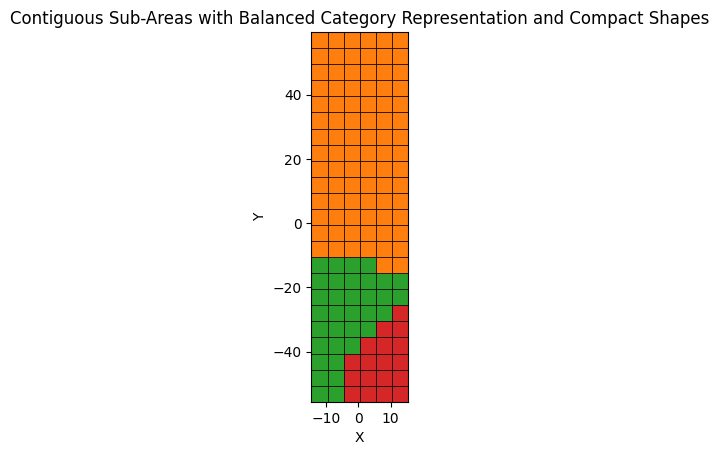

In [6]:
weights = [0.65, 0.2, 0.15]  # Intended area weights: training, evaluation, test
iterations = 1000  # Number of iterations to run
min_percentage_threshold = 8  # Minimum acceptable percentage per category per area
verbose = True  # Whether to print detailed statistics

# Create an instance of GridSplitter
grid_splitter = GridSplitter(
    counts=counts,
    x_edges=x_edges,
    y_edges=y_edges,
    weights=weights,
    iterations=iterations,
    min_percentage_threshold=min_percentage_threshold,
    verbose=verbose
)

# Run the algorithm
grid_splitter.run(random_seed=9897853)

# Plot the result
grid_splitter.plot()

Processing Fold 1
Fold 1 has 2 rectangles with total perimeter 46.


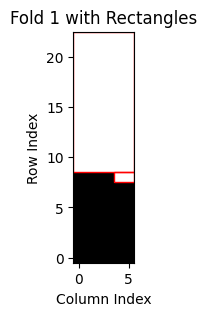

Processing Fold 2
Fold 2 has 5 rectangles with total perimeter 46.


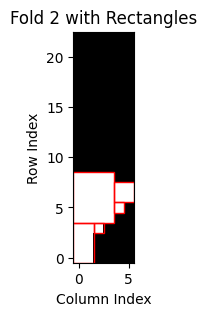

Processing Fold 3
Fold 3 has 4 rectangles with total perimeter 30.


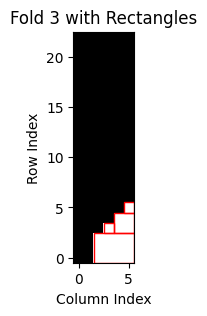

In [7]:
# Process the folds and get the rectangles
fold_rectangles = process_folds(grid_splitter.best_grid)

In [8]:
persist_best_iteration(gridsplitter=grid_splitter, fold_rectangles=fold_rectangles, filename='park_row_3fold.pkl')

Data from the best iteration has been saved to park_row_3fold.pkl


In [9]:
loaded_data = load_best_iteration('park_row_3fold.pkl')

20:03:34 - INFO - Best Iteration: 651


Data from park_row_3fold.pkl has been loaded successfully.


20:03:34 - INFO - Best Equality Score: 12495.7565
20:03:34 - INFO - 
Final category counts per area:

Area 1:
  Area size: 86 cells (62.32% of total, intended 65.00%)
  3_ROOF: 45938 points (69.84% of total 3_ROOF)
  5_FOOTPATH: 57970 points (55.41% of total 5_FOOTPATH)
  6_GRASS: 16976 points (65.34% of total 6_GRASS)
  7_COLUMN: 23737 points (67.14% of total 7_COLUMN)
  8_DOOR: 10470 points (73.38% of total 8_DOOR)
  9_WINDOW: 10657 points (56.29% of total 9_WINDOW)
  10_STAIR: 6447 points (69.39% of total 10_STAIR)
  11_RAILING: 3410 points (54.04% of total 11_RAILING)
  12_RWP: 473 points (57.47% of total 12_RWP)
  13_OTHER: 3677 points (54.69% of total 13_OTHER)
  Total points in area: 179755

Area 2:
  Area size: 34 cells (24.64% of total, intended 20.00%)
  3_ROOF: 13589 points (20.66% of total 3_ROOF)
  5_FOOTPATH: 30349 points (29.01% of total 5_FOOTPATH)
  6_GRASS: 7207 points (27.74% of total 6_GRASS)
  7_COLUMN: 3243 points (9.17% of total 7_COLUMN)
  8_DOOR: 1651 points (1

In [10]:
fold_meshes = crop_meshes_per_fold(
    dh.extracted_meshes,
    loaded_data['fold_rectangles'],
    loaded_data['x_edges'],
    loaded_data['y_edges']
)

20:03:34 - INFO - Processing Fold 1
20:03:38 - INFO - Processing Fold 2
20:03:43 - INFO - Processing Fold 3


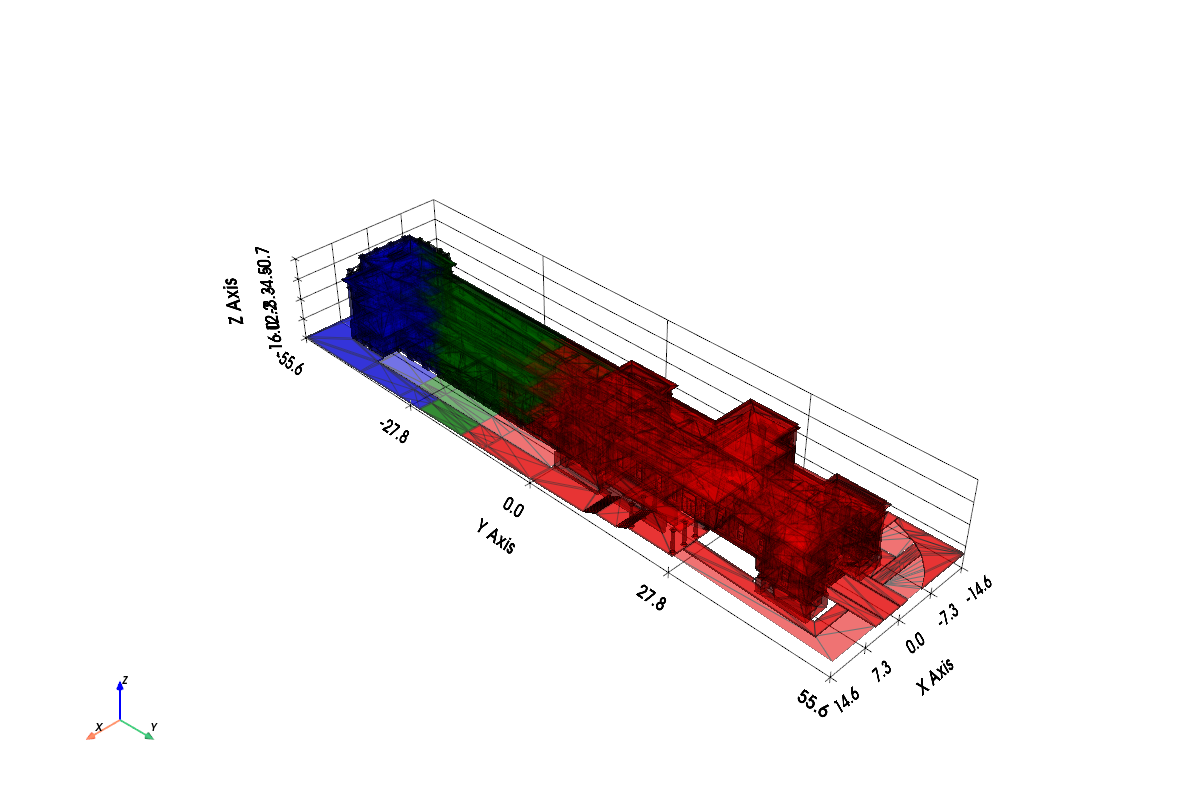

In [11]:
plot_mesh_folds(fold_meshes)

In [15]:
fold_meshes[1]['1_WALL']

UnstructuredGrid (0x7df3843d4ac0)
  N Cells:    171601
  N Points:   102278
  X Bounds:   -1.200e+01, 1.033e+01
  Y Bounds:   -4.214e+01, 4.832e+01
  Z Bounds:   -1.572e+01, -3.059e+00
  N Arrays:   2

In [28]:
fold_name_map = {
    1: 'train',
    2: 'test',
    3: 'eval',
}

fold_meshes_2 = {fold_name_map[k]: v for k, v in fold_meshes.items()}
fold_meshes_2

{'train': {'1_WALL': PolyData (0x7df3844fe2c0)
    N Cells:    171546
    N Points:   101735
    N Strips:   0
    X Bounds:   -1.200e+01, 1.033e+01
    Y Bounds:   -1.559e+01, 4.832e+01
    Z Bounds:   -1.572e+01, -3.059e+00
    N Arrays:   2,
  '2_FLOOR': PolyData (0x7df3844ffd00)
    N Cells:    11387
    N Points:   7505
    N Strips:   0
    X Bounds:   -1.074e+01, 9.085e+00
    Y Bounds:   -1.559e+01, 4.706e+01
    Z Bounds:   -1.573e+01, -4.879e+00
    N Arrays:   2,
  '3_ROOF': PolyData (0x7df3845e68c0)
    N Cells:    314
    N Points:   177
    N Strips:   0
    X Bounds:   -1.096e+01, 1.460e+01
    Y Bounds:   -1.559e+01, 4.705e+01
    Z Bounds:   -7.817e+00, -1.429e+00
    N Arrays:   2,
  '4_CEILING': PolyData (0x7df3845e40a0)
    N Cells:    16676
    N Points:   4911
    N Strips:   0
    X Bounds:   -1.037e+01, 9.085e+00
    Y Bounds:   -1.559e+01, 4.707e+01
    Z Bounds:   -1.333e+01, -3.680e+00
    N Arrays:   2,
  '5_FOOTPATH': PolyData (0x7df3845e6920)
    N Cells: 

In [30]:
import vtk
def save_splits(dh, splits):
    """
    Merge cells for each fold-category permutation and save them to disk.

    Args:
        dh (DataHandler): An object with a split_dirs attribute, containing directories for 'train', 'test', 'eval'.
        splits (dict): A dictionary containing fold-category mappings of cells. 
                       Example: {'train': {'category1': [cell1, cell2, ...], 'category2': [...]}}

    Returns:
        None: The function saves the merged meshes directly to disk.
    """
    dh._ensure_split_dirs()
    # Iterate over the splits dictionary (e.g., 'train', 'test', 'eval')
    for fold, categories in splits.items():
        # Get the appropriate directory for the fold from DataHandler
        fold_dir = dh.split_dirs.get(fold)
        cell_counter = 0
        # Iterate over each category in the fold
        for category, mesh in categories.items():
            if mesh.n_points == 0 and combined_mesh.n_cells == 0:
                logger.warn(f"Fold: {fold}, Category: {category} has an empty mesh!")
            mesh.GetPointData().SetActiveNormals('Normals')

            output_file = fold_dir / f"{category.lower()}.ply"           
            # Save the merged mesh to disk using vtk for control over color storage
            writer = vtk.vtkPLYWriter()
            writer.SetFileName(output_file.as_posix())
            writer.SetInputData(mesh)
            writer.SetColorModeToDefault()  # Ensure colors are written from the Scalars
            writer.SetArrayName('RGB')
            writer.Write()
            logger.info(f"Fold {fold}, category {category} saved.")

save_splits(dh, fold_meshes_2)

20:26:16 - INFO - Fold train, category 1_WALL saved.
20:26:16 - INFO - Fold train, category 2_FLOOR saved.
20:26:16 - INFO - Fold train, category 3_ROOF saved.
20:26:16 - INFO - Fold train, category 4_CEILING saved.
20:26:16 - INFO - Fold train, category 5_FOOTPATH saved.
20:26:16 - INFO - Fold train, category 6_GRASS saved.
20:26:16 - INFO - Fold train, category 7_COLUMN saved.
20:26:16 - INFO - Fold train, category 8_DOOR saved.
20:26:17 - INFO - Fold train, category 9_WINDOW saved.
20:26:17 - INFO - Fold train, category 10_STAIR saved.
20:26:17 - INFO - Fold train, category 11_RAILING saved.
20:26:17 - INFO - Fold train, category 12_RWP saved.
20:26:17 - INFO - Fold train, category 13_OTHER saved.
20:26:17 - INFO - Fold test, category 1_WALL saved.
20:26:17 - INFO - Fold test, category 2_FLOOR saved.
20:26:17 - INFO - Fold test, category 3_ROOF saved.
20:26:17 - INFO - Fold test, category 4_CEILING saved.
20:26:17 - INFO - Fold test, category 5_FOOTPATH saved.
20:26:17 - INFO - Fold

In [26]:
import vtk

def map_grid_to_spatial(min_col, max_col, min_row, max_row, x_edges, y_edges):
    """
    Map grid indices to spatial coordinates using x_edges and y_edges.
    
    Parameters:
        min_col, max_col, min_row, max_row (int): Grid indices.
        x_edges, y_edges (array-like): Bin edges for x and y axes.
    
    Returns:
        tuple: xmin, xmax, ymin, ymax mapped to spatial coordinates.
    """
    xmin = x_edges[min_col]
    xmax = x_edges[max_col + 1]  # +1 because x_edges has length grid_size_x + 1
    ymin = y_edges[min_row]
    ymax = y_edges[max_row + 1]  # +1 because y_edges has length grid_size_y + 1
    return xmin, xmax, ymin, ymax
    
def crop_meshes_per_fold(category_meshes, fold_rectangles, x_edges, y_edges):
    """
    Crop meshes for each fold based on rectangular bounding boxes using sequential plane clipping.

    Parameters:
        category_meshes (dict): Dictionary of category names and corresponding PyVista meshes.
        fold_rectangles (dict): Dictionary of fold IDs and bounding boxes.
        x_edges (array-like): Bin edges for x-axis.
        y_edges (array-like): Bin edges for y-axis.

    Returns:
        dict: A dictionary containing cropped meshes for each fold and category.
    """
    fold_meshes = {}
    for fold_id, rectangles in fold_rectangles.items():
        logging.info(f"Processing Fold {fold_id}")
        
        # For each category, we'll create a list to store cropped meshes
        fold_category_meshes = {}
        
        for category, mesh in category_meshes.items():
            mesh = pv.wrap(mesh)  # Ensure the mesh is a PyVista object
            
            # Initialize an empty list to collect cropped meshes for this category and fold
            cropped_meshes = []
            
            for rect in rectangles:
                # Map grid indices to spatial coordinates
                xmin, xmax, ymin, ymax = map_grid_to_spatial(
                    rect['min_col'], rect['max_col'], rect['min_row'], rect['max_row'], x_edges, y_edges)
                
                # Create planes for clipping
                planes = [
                    ('x', xmin, False),  # Left plane
                    ('x', xmax, True),   # Right plane
                    ('y', ymin, False),  # Bottom plane
                    ('y', ymax, True),   # Top plane
                ]
                
                # Start with the original mesh and sequentially clip with each plane
                clipped_mesh = mesh
                for axis, origin, invert in planes:
                    normal = {'x': (1, 0, 0), 'y': (0, 1, 0)}[axis]
                    point = [origin, 0, 0] if axis == 'x' else [0, origin, 0]
                    clipped_mesh = clipped_mesh.clip(normal=normal, origin=point, invert=invert)
                    if clipped_mesh.n_points == 0:
                        break  # No points left, exit early
                if clipped_mesh.n_points > 0:
                    cropped_meshes.append(clipped_mesh)
                else:
                    logging.debug(f"Cropping resulted in empty mesh for rectangle {rect} in category {category}")
                
            # Merge the cropped meshes for this category and fold
            if cropped_meshes:
                combined_mesh = cropped_meshes[0]
                for cm in cropped_meshes[1:]:
                    combined_mesh = combined_mesh.merge(cm, merge_points=True, main_has_priority=False)
                fold_category_meshes[category] = combined_mesh
            else:
                logging.warning(f"No mesh data in Fold {fold_id} for category {category}")
        
        # Store the combined meshes per fold
        fold_meshes[fold_id] = fold_category_meshes

    return fold_meshes

    
fold_meshes = crop_meshes_per_fold(
    dh.extracted_meshes,
    loaded_data['fold_rectangles'],
    loaded_data['x_edges'],
    loaded_data['y_edges']
)

20:24:50 - INFO - Processing Fold 1
20:24:57 - INFO - Processing Fold 2
20:25:12 - INFO - Processing Fold 3


In [31]:
dh.generate_and_save_fold_clouds(resolution=0.05, poisson_radius=0.049, save_all_formats=True)

20:28:16 - INFO - Number of points after initial sampling: 35689315
20:28:35 - INFO - Number of points after Poisson Disk Sampling: 2675486
20:28:36 - INFO - Saving cloud as .las format...
20:28:39 - INFO - Saved as: ../data/clouds/res0.05_pr0.049/park_row/train/1_wall.las
20:28:40 - INFO - Saved point cloud to ../data/clouds/res0.05_pr0.049/park_row/train/1_wall.pth in .pth format.
20:28:40 - INFO - Number of points after initial sampling: 4100358
20:28:43 - INFO - Number of points after Poisson Disk Sampling: 1016903
20:28:43 - INFO - Saving cloud as .las format...
20:28:45 - INFO - Saved as: ../data/clouds/res0.05_pr0.049/park_row/train/2_floor.las
20:28:45 - INFO - Saved point cloud to ../data/clouds/res0.05_pr0.049/park_row/train/2_floor.pth in .pth format.
20:28:45 - INFO - Number of points after initial sampling: 3631659
20:28:47 - INFO - Number of points after Poisson Disk Sampling: 554406
20:28:47 - INFO - Saving cloud as .las format...
20:28:48 - INFO - Saved as: ../data/clou